# imports 

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Callable, Dict

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
from shared.enums import DatasetType, EvaluationLevel

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/')
PATH_DNET = PATH/'DNETs'
PATH_DNET_WSIS = PATH_DNET/'wsis'
PATH_GANGLIOGLIOMA = PATH/'Ganglioglioma'


seed = 42
np.random.seed(seed)

# data

## wsi and json paths

In [5]:
wsi_paths_dnets = fastai.data.transforms.get_files(path=PATH_DNET_WSIS, extensions=['.ndpi'])
wsi_paths_ganglioglioma = fastai.data.transforms.get_files(path=PATH_GANGLIOGLIOMA, extensions=['.ndpi'])
wsi_paths = list(wsi_paths_dnets+wsi_paths_ganglioglioma)

json_paths_dnets = fastai.data.transforms.get_files(path=PATH_DNET, extensions=['.json'])
json_paths_ganglioglioma = fastai.data.transforms.get_files(path=PATH_GANGLIOGLIOMA, extensions=['.json'])
json_paths = list(json_paths_dnets+json_paths_ganglioglioma)

In [6]:
print(len(wsi_paths_dnets))
print(len(json_paths_dnets))
print(len(wsi_paths_ganglioglioma))
print(len(json_paths_ganglioglioma))

55
52
176
167


## wsi path to json file mapping and roi creation

In [7]:
def get_json_path_for_wsi(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])->pathlib.Path:
    """
    Arguments:
        wsi_path: path to whole-slide image
        json_paths: a list of paths to all json files, which contain the coordinates of region of interests of the
                    corresponding wsi
    Returns:
        Returns path of corresponding json file or raises FileNotFoundError, if json file cannot be found in json_paths
    """
    wsi_name = wsi_path.stem
    for jp in json_paths:
        if(wsi_name == jp.stem):
            return jp
    
    raise FileNotFoundError(f'json file could not be found for {wsi_path}')

        
def get_rois_from_wsi_path(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])\
                            ->List[wsi_processing_pipeline.shared.roi.RegionOfInterestPolygon]:
    json_path = get_json_path_for_wsi(wsi_path=wsi_path, json_paths=json_paths)
    return roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path)

In [8]:
wsi_paths_all_without_corresponding_json_file = []
wsi_path_to_json_path = {}

for wp in wsi_paths:
    try:
        json_path = get_json_path_for_wsi(wsi_path=wp, json_paths=json_paths)
        wsi_path_to_json_path[wp] = json_path
        
        #if(json_path in duplicates):
        #if(json_path in jps):
        #    print(wp)
        #jps.append(json_path)
    except FileNotFoundError:
        wsi_paths_all_without_corresponding_json_file.append(wp)

In [9]:
wsi_paths_all_without_corresponding_json_file

[Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1365-13-I2.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1825-18-I13.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1684 18-I8.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1825-18-I7.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N164-19-5.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N402-16.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N829-17-IV2.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N1531-15-II3.1.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N1531-15-II6.ndpi'),
 Path('/home/Deep_Learner/p

In [10]:
wsi_paths_with_json_files = list(wsi_path_to_json_path.keys())

In [11]:
wsi_path_to_rois = {}
for wp in wsi_paths_with_json_files:
    wsi_path_to_rois[wp] = get_rois_from_wsi_path(wsi_path=wp, json_paths=json_paths)

## id and label funcs

In [12]:
# one case per patient => patient id == case id
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return get_case_id_from_wsi_path(wsi_path=wsi_path)
    
def get_case_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    if('casus' in str(wsi_path.stem)):
        return wsi_path.stem
    split = wsi_path.stem.split('-')
    return f'{split[0]}-{split[1]}'    

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return wsi_path.stem

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None)->List[int]:
    if('Ganglioglioma' in str(wsi_path.parent)):
        return ['Ganglioglioma']
    if('DNETs' in str(wsi_path)):
        return ['DNET']
    raise AssertionError(f'No label could be determinated for {wsi_path}')

## tiles

In [13]:
tilesummaries = tiles.WsisToTilesParallel(wsi_paths=wsi_path_to_json_path.keys(), 
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          minimal_acceptable_tile_height=0.7, 
                                          minimal_acceptable_tile_width=0.7,
                                          tile_scoring_function=tiles.scoring_function_2,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois ,
                                          minimal_tile_roi_intersection_ratio=0.9, 
                                          verbose=False)

  0%|          | 0/218 [00:00<?, ?it/s]

Can't validate JPEG for directory 0: Expected marker at 4294975591, found none


  6%|▋         | 14/218 [00:23<02:21,  1.44it/s]

Can't validate JPEG for directory 0: Expected marker at 4294976039, found none


 13%|█▎        | 29/218 [00:36<02:25,  1.30it/s]

Can't validate JPEG for directory 0: Expected marker at 4294972560, found none
Can't validate JPEG for directory 0: Expected marker at 4294974338, found none


 28%|██▊       | 62/218 [01:07<01:50,  1.42it/s]

Can't validate JPEG for directory 0: Expected marker at 4294970859, found none
Can't validate JPEG for directory 0: Expected marker at 4294970978, found none


 30%|██▉       | 65/218 [01:08<01:31,  1.67it/s]

Can't validate JPEG for directory 0: Expected marker at 4294970979, found none


 44%|████▍     | 97/218 [01:37<01:26,  1.41it/s]

Can't validate JPEG for directory 0: Expected marker at 4294970798, found none
Can't validate JPEG for directory 0: Expected marker at 4294970878, found none


 45%|████▌     | 99/218 [01:38<01:08,  1.73it/s]

Can't validate JPEG for directory 0: Expected marker at 4294970918, found none
Can't validate JPEG for directory 0: Expected marker at 4294976126, found none
Can't validate JPEG for directory 0: Expected marker at 4294973902, found none


 52%|█████▏    | 113/218 [01:46<00:53,  1.95it/s]TopologyException: Input geom 0 is invalid: Self-intersection at or near point 89612.963333591149 37976.510000000002 at 89612.963333591149 37976.510000000002


The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fe08e0ea5d0>


 66%|██████▌   | 143/218 [02:05<00:59,  1.26it/s]

Can't validate JPEG for directory 0: Expected marker at 4294974266, found none
Can't validate JPEG for directory 0: Expected marker at 4294971043, found none


 67%|██████▋   | 145/218 [02:05<00:44,  1.63it/s]

Can't validate JPEG for directory 0: Expected marker at 4294970639, found none
Can't validate JPEG for directory 0: Expected marker at 4294976170, found none


 92%|█████████▏| 201/218 [03:01<01:41,  5.97s/it]

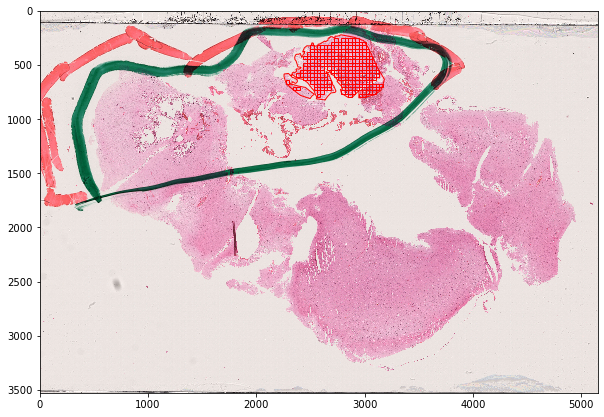

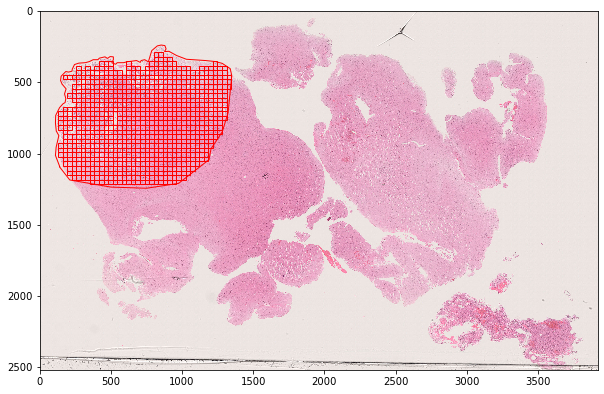

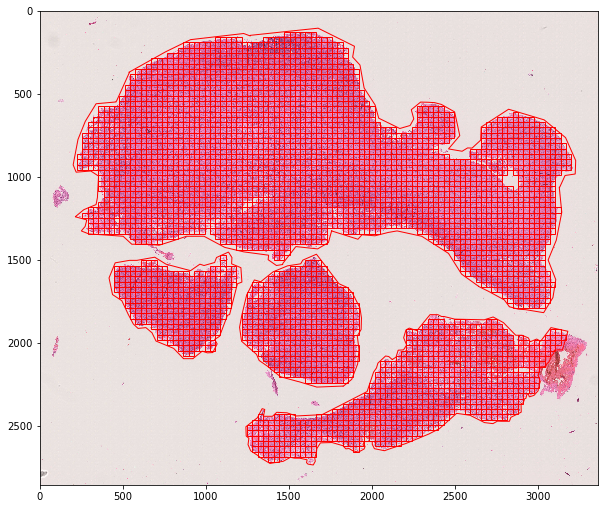

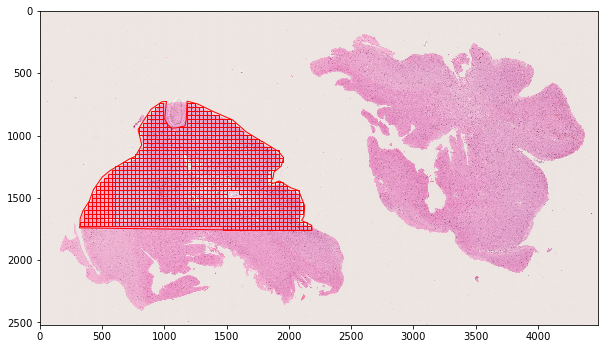

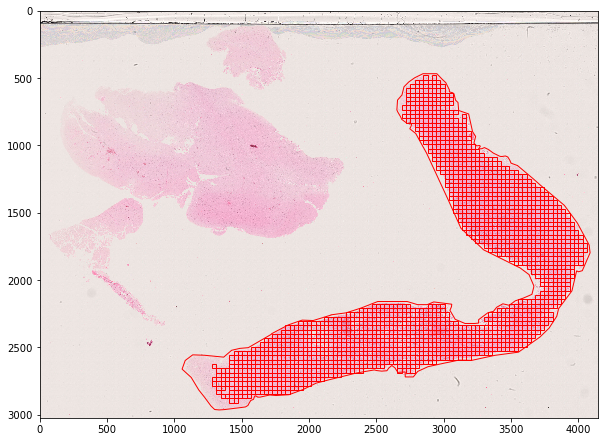

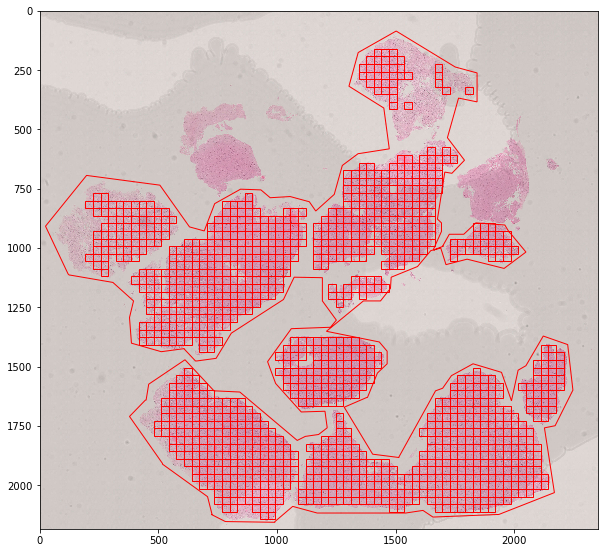

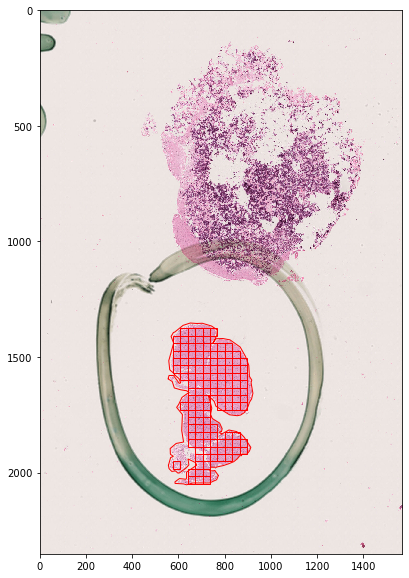

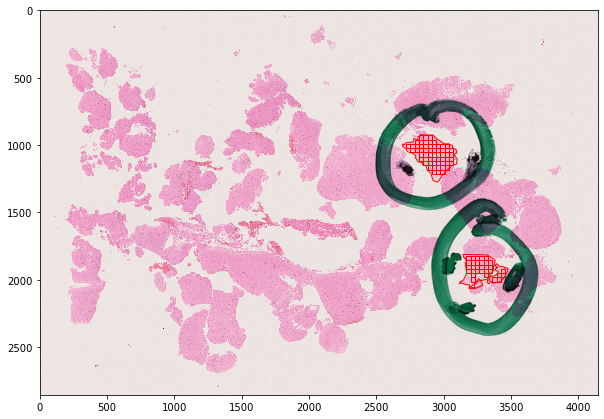

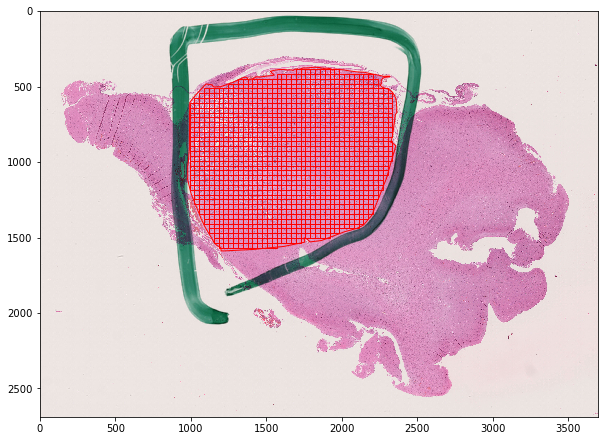

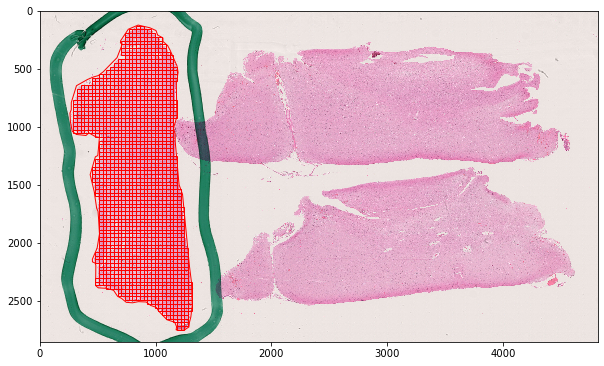

In [22]:
for ts in random.sample(tilesummaries, 10):
    ts.show_wsi_with_top_tiles()

## patient manager 

In [14]:
patient_manager = PatientManager()

In [15]:
patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, 
                                          case_id_getter=get_case_id_from_wsi_path, 
                                          slide_id_getter=get_slide_id_from_wsi_path, 
                                          labels_getter=get_labels_from_wsi_path)


100%|██████████| 201/201 [00:01<00:00, 117.48it/s]


In [16]:
train_size = 0.85
validation_size = 0.15
test_size = 0.0

patient_manager.split(train_size=train_size, validation_size=validation_size, test_size=test_size, random_state=seed)

In [17]:
class_distribution_all = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)

In [18]:
class_distribution_all

(206034,
 {'DNET': 34520, 'Ganglioglioma': 171514},
 {'DNET': 0.1675451624489162, 'Ganglioglioma': 0.8324548375510838})

In [19]:
class_distribution_train = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.train)

In [20]:
class_distribution_train

(170104,
 {'DNET': 27923, 'Ganglioglioma': 142181},
 {'DNET': 0.1641525184592955, 'Ganglioglioma': 0.8358474815407045})

In [21]:
class_distribution_valid = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.validation)

In [22]:
class_distribution_valid

(35930,
 {'DNET': 6597, 'Ganglioglioma': 29333},
 {'DNET': 0.1836070136376287, 'Ganglioglioma': 0.8163929863623712})

## data block api

In [24]:
final_size = 512
bs = 35

data = fastai.data.block.DataBlock(
        blocks=(TileImageBlock, fastai.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.get_labels(),
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms=fastai.vision.augment.Resize(size=final_size, method = 'squish'),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

dls = data.dataloaders(patient_manager.get_tiles(dataset_type=DatasetType.train)\
                        +patient_manager.get_tiles(dataset_type=DatasetType.validation), 
                       bs=bs, 
                       verbose=False)

In [27]:
len(patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.train))

170104

In [25]:
len(dls.train_ds)

170104

In [28]:
len(patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation))

35930

In [26]:
len(dls.valid_ds)

35930

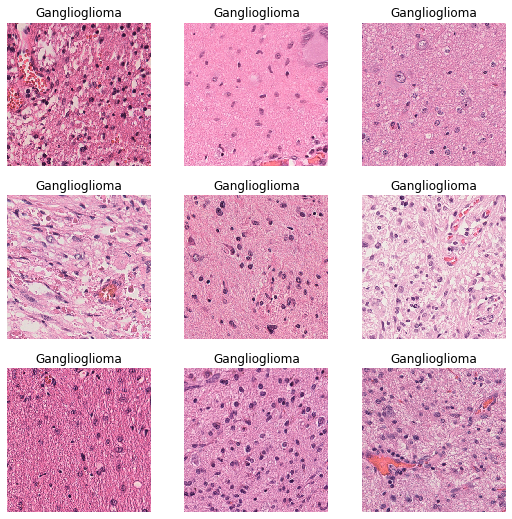

In [60]:
dls.show_batch()

# learner

## n

In [30]:
n=1

## create

In [31]:
#arch = torchvision.models.resnet.resnext101_32x8d
arch = torchvision.models.resnet50

In [32]:
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai.metrics.accuracy_multi],
                     pretrained=True,
                     path=PATH/'models'/f'{n}-{arch.__name__}')

In [33]:
learner.to_fp16()

In [34]:
learner.path

Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/models/1-resnet50')

In [35]:
learner.path.parent.mkdir(exist_ok=True)

In [36]:
learner.path.mkdir(exist_ok=True)

## name

In [37]:
epochs_frozen = 5
epochs_unfrozen = 10

In [38]:
nameBase = f'{n}-{arch.__name__}'
nameBase

'1-resnet50'

## train

In [ ]:
learner.lr_find(start_lr=1e-15, end_lr=10, num_it=200)

In [ ]:
learner.recorder.plot_lr_find()

In [72]:
lr1 = 

In [73]:
log_head_name = 'log-head.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_frozen, 
                      lr_max=lr1, 
                      cbs=[CSVLogger(fname=log_head_name, append=True), SaveModelCallback(every_epoch=True, fname='head')])

In [ ]:
pd.read_csv(learner.path/log_head_name)

In [ ]:
nameHead = f'{nameBase}-head';nameHead

In [ ]:
learner.save(nameHead)

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find(start_lr=1e-11, end_lr=10, num_it=500)

In [ ]:
learner.recorder.plot_lr_find()

In [ ]:
lr2 = 
lr3 = 
lr4 = 

In [ ]:
log_complete_name = 'log-complete.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_unfrozen, 
                      lr_max=[lr2, lr3, lr4], 
                      cbs=[CSVLogger(fname=log_complete_name, append=True), SaveModelCallback(every_epoch=True, fname='complete')])

In [ ]:
pd.read_csv(learner.path/log_complete_name)

In [ ]:
nameComplete = f'{nameBase}-complete'; nameComplete

In [ ]:
learner.save(nameComplete)

# prediction

# evaluation